In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
print("libraries imported")

libraries imported


Converting all images in the folder to PNG from PGM

In [2]:
#Conversion
for file in os.listdir():
    filename, extension = os.path.splitext(file)
    if extension == ".pgm":
        new_file = "{}.jpg".format(filename)
        with Image.open(file) as im:
            im.save(new_file)
            print(filename + ".jpg" + " has been saved")

MapSpin.jpg has been saved
MapUnlearnt.jpg has been saved
TheMap.jpg has been saved


Simple display on matplotlib

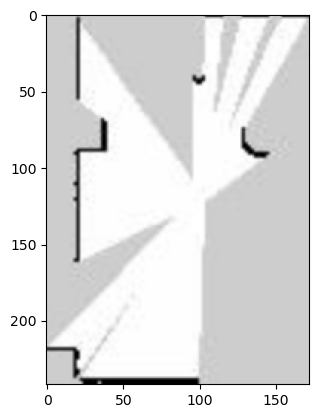

In [49]:
%matplotlib inline
mapImg = cv2.imread("MapSpin.jpg")
mapImg = cv2.resize(mapImg, (0,0), fx=2, fy=2)
imgplot = plt.imshow(mapImg, cmap="gray")
plt.show()

Isolating the wall using opencv

<Figure size 640x480 with 0 Axes>

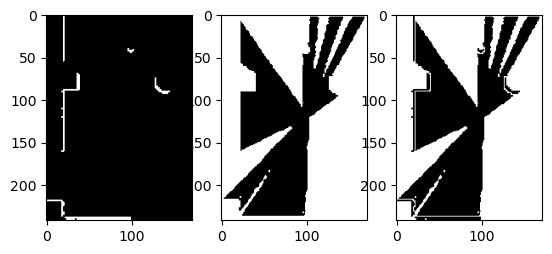

In [63]:
grayscaled = cv2.cvtColor(mapImg,cv2.COLOR_BGR2GRAY)
retval, threshold = cv2.threshold(grayscaled, 100, 255, cv2.THRESH_BINARY_INV)
retval2, threshold2 = cv2.threshold(grayscaled, 240, 255, cv2.THRESH_BINARY_INV)
unseenImage = cv2.subtract(threshold2, threshold)
plt.figure()
f, axarr = plt.subplots(1,3)
axarr[0].imshow(threshold, cmap="gray")
axarr[1].imshow(threshold2, cmap="gray")
axarr[2].imshow(unseenImage, cmap="gray")


In [55]:
import math
class GridSquare:
    def __init__(self, width, height, midx, midy, index=0, data=-1):
        self.width = width
        self.height = height
        listerine = []
        if data == -1:
            self.data = np.array(np.zeros((self.width, self.height)))
        else:
            self.data = data
        self.index = index
        self.midpoint = (midx, midy)

    def setMidpoint(self, midx, midy):
        self.midpoint = (midx, midy)

    def getSquareValue(self):    ##### THE LAST THING TO BE DONE WITH SETTING UP THE GRID
        total = 0
        for rows in self.data:
            for entry in rows:
                total +=  entry
        total = total / (self.width * self.height)
        return total

    def getIndex(self):
        return self.index
    
    def getMidPoint(self):
        return self.midpoint

    ##Prints off the square info
    def printSquareInfo(self):
        print("Width :", self.width)
        print("Height :", self.height)
        print("Data:")
        print(self.data)


##Class for the grid
class OccupancyGrid:
    ##Initialise the grid and create the data
    def __init__(self, map=None, resolutionConstruct=10):
        self.map = map
        if self.map is None:
             print("MAP ERROR, defaulting to (500,500) map of 0s")
             defaultMap = np.zeros((500,500), dtype="float")
             self.map = cv2.resize(defaultMap, (0,0), fx=1, fy=1)
        self.shape = self.map.data.shape
        self.data = np.zeros((self.map.shape[0], self.map.shape[1]))
        if resolutionConstruct < 1 or (resolutionConstruct**2 > (self.shape[0] * self.shape[1])):
            print("RESOLUTION ERROR, resolution defaulting to 1")
            self.resolution = 1
        else:
            self.resolution = resolutionConstruct
        
        self.squares = []

        if self.map.shape[0] == self.map.shape[1]:
            self.initialiseGrid()
        else:
            self.data = self.interpolateData()
            self.initialiseGrid()

        self.locations =[]


    ##Initiailising the grid
    def initialiseGrid(self):
        squareheight = math.ceil(self.map.shape[0] / self.resolution)
        squarewidth  = math.ceil(self.map.shape[1] / self.resolution)
        liste = []
        for y in range(squareheight):
            for x in range(squarewidth):
                index = (y*squarewidth) + (x)
                if x == 0:
                    strtPtrX = 0
                else: strtPtrX = x*self.resolution

                if y==0:
                    strtPtrY = 0
                else: strtPtrY = y*self.resolution
                tempData = self.createData(strtPtrX, strtPtrY, self.data, index)
                self.squares.append(tempData)
        print(f'Squares created: ({len(self.squares)})')


    ##Creates individual cells
    def createData(self, xOff, yOff, data, index):
        temp = GridSquare(width= self.resolution, height=self.resolution, index=index, data=-1, midx=xOff, midy=yOff)
        for y in range(self.resolution):
            if y+yOff < data.shape[1]:
                for x in range(self.resolution):
                    temp.setMidpoint(midx=math.ceil(xOff + (self.resolution/2)), midy= math.ceil(yOff + (self.resolution/2)))
                    temp.data[x, y] = data[x+xOff, y+yOff]
        return temp


    ##Interpolates the image to create a fair map for even cells
    def interpolateData(self):
        squareheight = math.ceil(self.map.shape[0] / self.resolution)
        squarewidth  = math.ceil(self.map.shape[1] / self.resolution)
        print(f'Grid cell arrangement: ')
        print(f'Squares wide: ({squarewidth})\nSquares high: ({squareheight})')
        resizeHeight = (math.ceil(self.map.shape[0]/self.resolution) * self.resolution)
        resizeWidth = (math.ceil(self.map.shape[1]/self.resolution) * self.resolution)
        print(f'Resized sizes: ({resizeWidth},{resizeHeight})')
        dst = cv2.resize((self.map), (resizeWidth, resizeHeight), interpolation = cv2.INTER_CUBIC)        
        return np.array(dst.data, dtype="int")


    ##Get the coordinates of the best square to move to
    def findBestSquareCoordinates(self):
        tempstore = list((zip()))

    ##Print off the grids info
    def printGridInfo(self):
        print(f'\nGrid information:')
        print(f'Grid Width: ({self.shape[1]})')
        print(f'Grid Height: ({self.shape[0]})')
        print(f'Grid square Resolution: ({self.resolution})')

    def getBestLocation(self):
        costPointList = []
        for square in self.squares:
            costPointList.append((square.getSquareValue(), square.getMidPoint()))
        return max(costPointList)
    
    def addLocation(self):
        location = self.getBestLocation()
        location = location[1]
        self.locations.append(location)

    def displayMap(self):
        copyer = self.data.copy()
        print("Starting line")
        print(len(self.locations))
        imageCenter = (int(copyer.shape[1]/2),int(copyer.shape[0]/2))
        cv2.circle(copyer, imageCenter, 3, (120,120,120), 1, 8, 0)
        if len(self.locations) == 1:
                    print("One point found.")
                    cv2.line(copyer, imageCenter, self.locations[0], (120,120,120), 3, 8)
                    cv2.circle(copyer, self.locations[0], 3, (120,120,120), 1, 8, 0)
                    cv2.circle(copyer, self.locations[0], 1, (120,120,120), 1, 8, 0)
                    print("Starting Line added")
                    plt.imshow(copyer)
                    return
        for location in range(len(self.locations)):
            print(f'Point number: {location}')
            if location == 0:
                    print("First point found.")
                    cv2.line(copyer, imageCenter, self.locations[0], (120,120,120), 2, 8)
                    cv2.circle(copyer, self.locations[0], 3, (120,120,120), 1, 8, 0)
                    cv2.circle(copyer, self.locations[0], 1, (120,120,120), 1, 8, 0)
                    print("Starting Line added")
            elif (location + 1 == len(self.locations)):
                    cv2.line(copyer, self.locations[location-1], self.locations[location], (120,120,120), 2, 8)
                    cv2.circle(copyer, self.locations[location], 5, (120,120,120), 2, 8, 0)
                    cv2.circle(copyer, self.locations[location], 1, (120,120,120), 1, 8, 0)
                    print("Path Ended.")
            else:
                    cv2.line(copyer, self.locations[location-1], self.locations[location], (120,120,120), 1, 8)
                    cv2.circle(copyer, self.locations[location], 3, (120,120,120), 1, 8, 0)
                    cv2.circle(copyer, self.locations[location], 1, (120,120,120), 1, 8, 0)
                    print("Path point added.")
            
        plt.imshow(copyer, cmap="gray")

    def testAddLocation(self, x, y):
        location = (x,y)
        self.locations.append(location)
        print(f'TESTING - LOCATION ADDED TO LIST: {location}')


    ##Need to do this
    # Once its been confirmed that the robot has moved to the point
    # spin, wait for a full rotato
    # Reload map,
    # adjust via the old size vs new size for each point
    # repeat
    # Develop cost algorithm,
    


    ##Where im at
    #Locations are set up to be followed and plotted onto the map
    #locations are added to the list
    #handled issues of only one,
    #need to check if its the last element
    #path is displayed
    #Need to edit add location to test multiple points

Grid cell arrangement: 
Squares wide: (4)
Squares high: (5)
Resized sizes: (200,250)
Squares created: (20)

Grid information:
Grid Width: (172)
Grid Height: (242)
Grid square Resolution: (50)

Best point: (255.0, (175, 175))
Starting line
1
One point found.
Starting Line added


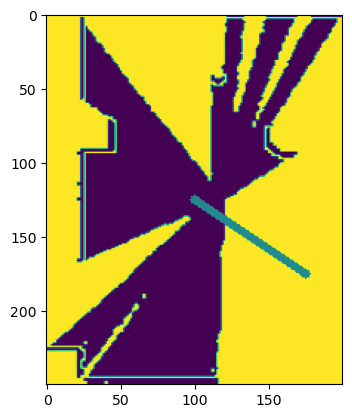

In [56]:
temp = OccupancyGrid(unseenImage, 50)
temp.printGridInfo()
point = temp.getBestLocation()
print(f'\nBest point: {point}')
temp.addLocation()
temp.displayMap()